In [1]:
from defaultPlots import scatter
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import scipy 
from helper import numToMonth

def getData(index, startYear, endYear, indexMonth):
        csv = pd.read_csv(r"C:\Users\deela\Downloads\composites - " + index + ".csv")
        csv = csv[(csv['Year'] >= startYear) & (csv['Year'] <= endYear)]
        csv = csv[numToMonth(indexMonth)[0:3]]

        return csv.to_numpy()

In [2]:
startYear = 1971
endYear = 2020
month = 6

nao = getData('nao', startYear, endYear, month)
amo = getData('amo', startYear, endYear, month)
pdo = getData('pdo', startYear, endYear, month)
amm = getData('amm', startYear, endYear, month)
pmm = getData('pmm', startYear, endYear, month)
oni6 = getData('oni', startYear, endYear, month)
tni6 = getData('tni', startYear, endYear, month)
oni1 = getData('oni', startYear, endYear, 1)
tni1 = getData('tni', startYear, endYear, 1)
aem = getData('atl3', startYear, endYear, month)
pna = getData('pna', startYear, endYear, month)

ace = getData('Cumulative NATL ACE', startYear, endYear, 12)
year = np.arange(startYear, endYear + 1, 1)


In [3]:
def regression(input, output, RF = True): 
    if RF == True:
        regr = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
        regr.fit(input, output) 
        predictTest = regr.predict(input)
    else:
        regr = linear_model.LinearRegression()
        regr.fit(input, output)
        predictTest = regr.predict(input)

    try:
        importance = regr.feature_importances_
    except:
        coef = np.abs(regr.coef_ * np.nanstd(input, axis = 0))
        importance = coef / np.sum(coef)

    corr, sig = scipy.stats.pearsonr(predictTest, output)
    # error = np.sqrt(np.mean((predictTest - testOut)**2))
    error = np.mean(np.abs(predictTest - output))
    scatter(['Predicted ACE', predictTest], ['ACE', output])#, hline = False, vline = False)

    print(str(error) + f" ACE error\nCorrelation: {corr**2}")

    return regr, predictTest, importance, input, output

50 (50,)
[[1.]]
8.26501122684327 173.923125585902


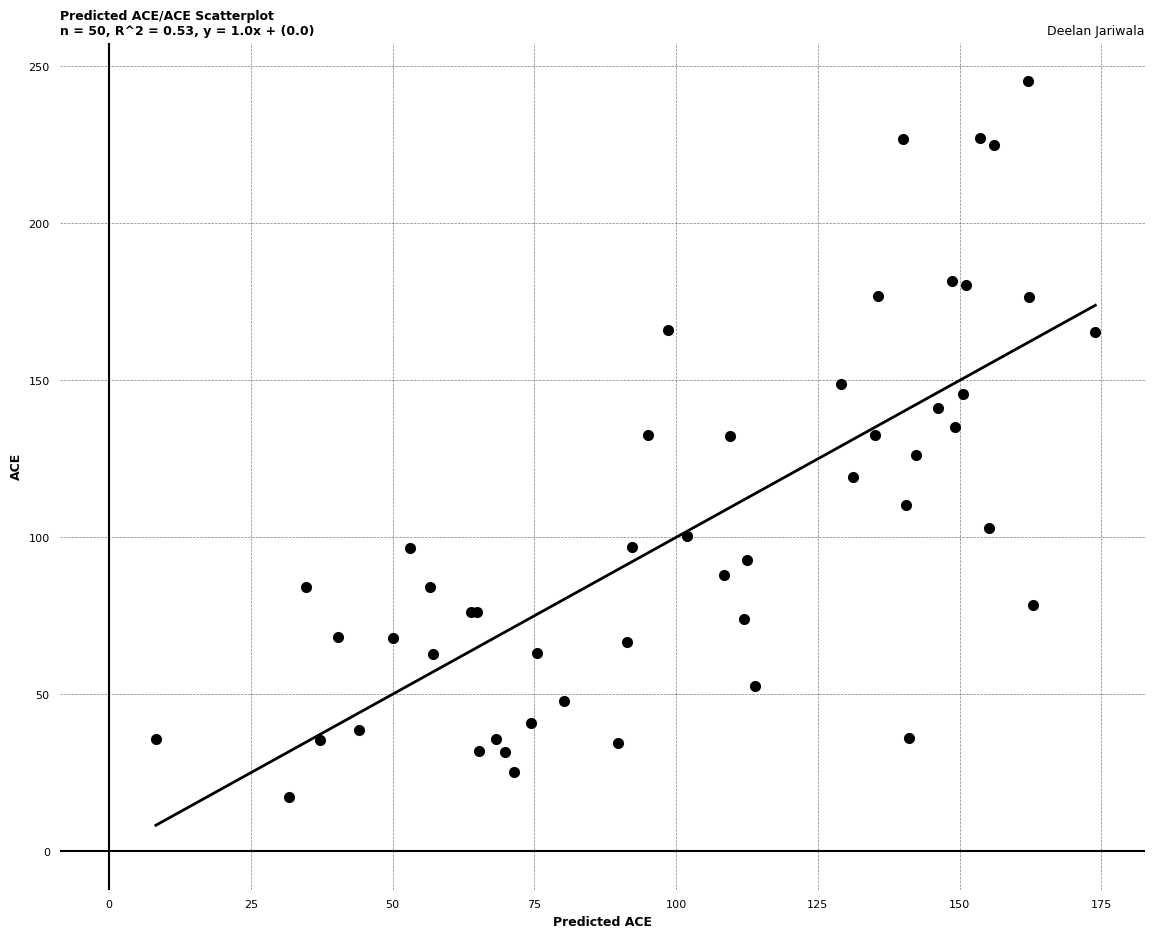

32.22335485256794 ACE error
Correlation: 0.5316369088373913
Feature:                                 NAO, Importance: 0.03339761960135105
Feature:                                 AMO, Importance: 0.35407099751768395
Feature:                                 PDO, Importance: 0.06483376502258964
Feature:                                 AMM, Importance: 0.09351977262435565
Feature:                                 PMM, Importance: 0.11577772573869538
Feature:                             ONI_Jun, Importance: 0.1159486149169923
Feature:                             TNI_Jun, Importance: 0.025070790872690794
Feature:                             ONI_Jan, Importance: 0.07942462264719845
Feature:                             TNI_Jan, Importance: 0.05442388138380821
Feature:                                ATL3, Importance: 0.039581478731770335
Feature:                                 PNA, Importance: 0.023950730942864207


1971 96.5275 53.07336197055827
1972 35.605 8.26501122684327
1973 47.85 80.1564

In [4]:
xNames = ['NAO', 'AMO', 'PDO', 'AMM', 'PMM', 'ONI_Jun', 'TNI_Jun', 'ONI_Jan', 'TNI_Jan', 'ATL3', 'PNA']
x = np.array([nao, amo, pdo, amm, pmm, oni6, tni6, oni1, tni1, aem, pna]).T
y = ace
regr, predictTest, importance, input, output = regression(x, y, RF = False)

feat = dict(zip(xNames, importance))
# Print one key-value pair at a time
for key, value in feat.items():
    print(f"Feature: {key:>35}, Importance: {value}")
print('\n')
for x in range(len(year)):
    print(year[x], y[x], predictTest[x])

print(list(y - predictTest))

In [5]:
import xarray as xr 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import cartopy
import numpy as np 
import cmaps as cmap 
import pandas as pd 
from helper import numToMonth
import scipy.stats
from scipy.signal import detrend
import matplotlib as mpl
from ersstTimeseriesGenerator import timeseries 
from regionalACE import createClimoData
from correlationPCA import pcaSeries
import psl
import helper
from scipy.ndimage import gaussian_filter
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['font.family'] = 'Courier New'

def map(interval, labelsize):
    fig = plt.figure(figsize=(14, 6))

    # Add the map and set the extent
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_frame_on(False)
    
    # Add state boundaries to plot
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth = 0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth = 0.25)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth = 0.25)
    ax.set_xticks(np.arange(-180, 181, interval), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, interval), crs=ccrs.PlateCarree())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())

    ax.tick_params(axis='both', labelsize=labelsize, left = False, bottom = False)
    ax.grid(linestyle = '--', which = 'major', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
    # ax.grid(linestyle = '--', which = 'minor', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
    # ax.minorticks_on()
    return ax 

def yearlySum(data):
    values = data.values
    values = values.reshape(int(values.shape[0] / 12), 12, 71, 181)
    values = np.sum(values, axis = 1)

    data = data.resample(time = 'AS').mean()
    data.values = values

    return data

def getIndex(ts = False, ACEbox = False, SSTAbox = False, EOFbox = False, **kwargs):
    if ts == True: 
        # index = 'Zach_Residuals'
        # indexMonth = '12'
        # dataMonth = '6'
        # startYear = 1980
        # endYear = 2024
        print(startYear, endYear)
        csv = pd.read_csv(r"C:\Users\deela\Downloads\composites - " + index + ".csv")
        csv = csv[(csv['Year'] >= startYear) & (csv['Year'] <= endYear)]
        print(csv)
        csv = csv[numToMonth(indexMonth)[0:3]]
    elif ACEbox == True:
        # startYear = 1971
        # endYear = 2023
        # indexMonth = '8'
        # dataMonth = '8'
        # day = 365
        # day2 = 233
        # index = f'ACE in Box (to day {day})'
        # lats = [0, 70]
        # lons = [-120, -1]
        boxXCoords = [lons[0], lons[1], lons[1], lons[0], lons[0]]
        boxYCoords = [lats[0], lats[0], lats[1], lats[1], lats[0]]
        csv = createClimoData([startYear, endYear], 'AL', lats, [lons[0] - 360, lons[1] - 360])
        print(csv)
        try:
            csv = csv[day] - csv[day2]
        except:
            csv = csv[day]
    elif SSTAbox == True:
        # startYear = 1971
        # endYear = 2020
        # indexMonth = '7'
        # dataMonth = '7'
        # index = 'SSTAs in Box'
        # lats = [40, 60]
        # lons = [360-70, 360-35]
        boxXCoords = [lons[0], lons[1], lons[1], lons[0], lons[0]]
        boxYCoords = [lats[0], lats[0], lats[1], lats[1], lats[0]]
        csv = timeseries(indexMonth, range(startYear, endYear + 1), slice(lats[1], lats[0]), slice(lons[0], lons[1]))[numToMonth(indexMonth)[0:3]]
    elif EOFbox == True:
        # startYear = 1971
        # endYear = 2023
        # indexMonth = '9'
        # dataMonth = '9'
        # eofNum = 2
        # index = f'EOF{eofNum} of Box'
        # lats = [0, 70]
        # lons = [280, 360]
        boxXCoords = [lons[0] - 360, lons[1] - 360, lons[1] - 360, lons[0] - 360, lons[0] - 360]
        boxYCoords = [lats[0], lats[0], lats[1], lats[1], lats[0]]
        csv = pcaSeries(startYear, endYear, lats, lons, indexMonth, eofNum)[numToMonth(indexMonth)[0:3]]
    
    return csv


In [6]:
ERSSTDATA = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc')
dataset1 = ERSSTDATA
print(dataset1)
dataset = dataset1['sst']
data = dataset.fillna(0) * np.cos(np.radians(dataset['lat']))
print(data)

# dataset1 = xr.open_dataset(r"C:\Users\deela\Downloads\HURDAT2DensityALL2025.nc")
# dataset = dataset1['ACE']
# data = dataset * np.cos(np.deg2rad(dataset['latitude']))
# print(data.shape)
# data = yearlySum(data)
# data = data.coarsen(latitude=2, longitude=2, boundary='trim').mean()

# s = 3
# data.values = gaussian_filter(data.values, sigma = s, axes = (1, 2))
# print(data)

<xarray.Dataset> Size: 132MB
Dimensions:    (lat: 89, lon: 180, time: 2058, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-06-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 33kB ...
    sst        (time, lat, lon) float32 132MB ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                       

['', 'HURDAT2 April 04, 2025', '\r', '    \r', 'AL011851,            UNNAMED,     14,\r', '18510625, 0000,  , HU, 28.0N,  94.8W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\r', '18510625, 0600,  , HU, 28.0N,  95.4W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\r', '18510625, 1200,  , HU, 28.0N,  96.0W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\r', '18510625, 1800,  , HU, 28.1N,  96.5W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\r', '18510625, 2100, L, HU, 28.2N,  96.8W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\r', '18510626, 0000,  , HU, 28.2N,  97.0W,  70, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\r', '18510626, 0600,  , TS, 28.3N,  97.6W,  60, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -9

C:\Users\deela\AppData\Local\Temp\ipykernel_51544\2926547322.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, sig = scipy.stats.pearsonr(temp[:, x], csv)


(16020,)
[260, 360] [0, 0]
[360, 360] [0, 70]
[360, 260] [70, 70]
[260, 260] [70, 0]


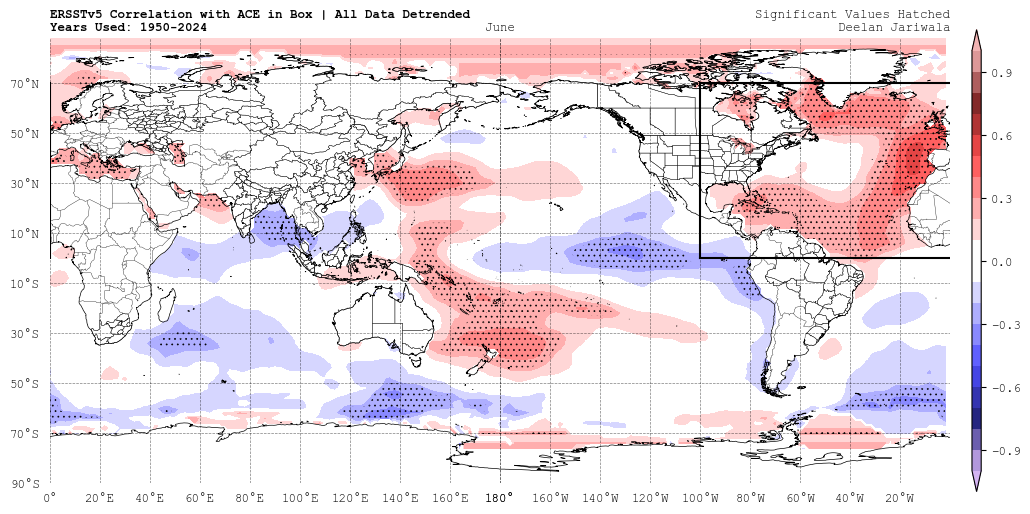

In [7]:
index = 'ACE in Box'
dataMonth = '6'
indexMonth = '12'
startYear = 1950
endYear = 2024
day = 365
lats = [0, 70]
lons = [360 - 100, 360 - 0]
boxXCoords = [lons[0], lons[1], lons[1], lons[0], lons[0]]
boxYCoords = [lats[0], lats[0], lats[1], lats[1], lats[0]]
csv = getIndex(ACEbox= True, dataMonth = dataMonth, day = day, startYear = startYear, endYear = endYear, lats = lats, lons = lons)
print(csv)

fMonths = np.array([np.datetime64(f'{y}-{str(dataMonth).zfill(2)}-01') for y in range(startYear, endYear + 1)])
data = data.sel(time = fMonths)
ogShape = data.shape

temp = data.values
temp = np.reshape(temp, (ogShape[0], ogShape[1] * ogShape[2]))
temp = detrend(temp, axis = 0)
print(temp.shape, csv.shape)

corrData = []
signData = []
for x in range(temp.shape[1]):
    temp[:, x] = np.nan_to_num(temp[:, x])
    corr, sig = scipy.stats.pearsonr(temp[:, x], csv)
    corrData.append(corr)
    signData.append(sig)

print(np.array(corrData).shape)
data = data.mean('time')
data.values = np.reshape(corrData, (ogShape[1], ogShape[2]))
dataset1['sig'] = ((ogShape[1], ogShape[2]), np.reshape(signData, (ogShape[1], ogShape[2])))

ax = map(20, 9)
# ax.set_extent([180, 359.9, 0, 70], crs = ccrs.PlateCarree())
try:
    c = plt.contourf(data.longitude, data.latitude, data.values, cmap = cmap.tempAnoms3(), levels = np.arange(-1, 1.1, .1), extend = 'both', transform = ccrs.PlateCarree(central_longitude = 0))
    # c = plt.pcolormesh(data.longitude, data.latitude, data.values, cmap = cmap.tempAnoms3(), vmin = -1, vmax = 1.1, transform = ccrs.PlateCarree(central_longitude = 0))
    h = plt.contourf(data.longitude, data.latitude, dataset1['sig'].values, colors = 'none', levels = np.arange(0, 0.06, 0.01), hatches = ['...'], transform = ccrs.PlateCarree(central_longitude = 0))
except:
    c = plt.contourf(data.lon, data.lat, data.values, cmap = cmap.tempAnoms3(), levels = np.arange(-1, 1.1, .1), extend = 'both', transform = ccrs.PlateCarree(central_longitude = 0))
    # c = plt.pcolormesh(data.lon, data.lat, data.values, cmap = cmap.tempAnoms3().reversed(), vmin = -1, vmax = 1.1, transform = ccrs.PlateCarree(central_longitude = 0))
    h = plt.contourf(data.lon, data.lat, dataset1['sig'].values, colors = 'none', levels = np.arange(0, 0.06, 0.01), hatches = ['...'], transform = ccrs.PlateCarree(central_longitude = 0))

try:
    for y in range(len(boxXCoords)):
        try:
            print([boxXCoords[y], boxXCoords[y + 1]], [boxYCoords[y], boxYCoords[y + 1]])
            ax.plot([boxXCoords[y], boxXCoords[y + 1]], [boxYCoords[y], boxYCoords[y + 1]], color = 'black', zorder = 20, transform = ccrs.PlateCarree(central_longitude = 360))
        except:
            pass
except:
    pass

try:
    for collection in h.collections:
        collection.set_edgecolor('#262626')
        collection.set_linewidth(0)
except:
    pass

# ax.set_title(f'NCEP/NCAR R1 850mb Zonal Wind Correlation with {index} | All Data Detrended\nYears Used: {startYear}-{endYear}', fontweight='bold', fontsize=9, loc='left')
# ax.set_title(f'ERSSTv5 Correlation with {numToMonth(indexMonth)} {index} | All Data Detrended\nYears Used: {startYear}-{endYear}', fontweight='bold', fontsize=9, loc='left')
#ax.set_title(f'AMSU Tropopause (TTS) Brightness Temp. Correlation with {numToMonth(indexMonth)} {index} | All Data Detrended\nYears Used: {startYear}-{endYear}', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'ERSSTv5 Correlation with {index} | All Data Detrended\nYears Used: {startYear}-{endYear}', fontweight='bold', fontsize=9, loc='left')
# ax.set_title(f'HURDAT2 ACE Density Correlation with {numToMonth(indexMonth)} {index.upper()}\nYears Used: {startYear}-{endYear}', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'{numToMonth(dataMonth)}', fontsize=9, loc='center') 
ax.set_title(f'Significant Values Hatched\nDeelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
# plt.savefig(r"C:\Users\deela\Downloads\correlationPlot" + dataMonth + "_" + index + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [8]:
correlationArray = data.values

In [9]:
def computeClimo(data, month, year):
    if year - 30 < 1854:
        allYears = range(1854, 1883)
    else:
        allYears = range(year - 30, year - 1)
    allYears = [np.datetime64(f'{y}-{month.zfill(2)}-01') for y in allYears]
    data = data.sel(time = allYears)

    return data

def std(dataset, average):
    dev = []
    for x in range(29):
        temp = dataset.isel(time = x)
        dev.append((average.values - temp.values)**2)
    dataset = dataset.mean('time')
    dataset.values = np.sqrt(sum(dev) / len(dev))
    stddev = dataset
    return stddev

def anomalies(month, years, sd = False):
    dataset = ERSSTDATA['sst']
    allData = []
    for year in years:
        climo = computeClimo(dataset, month, int(year))

        data = dataset.sel(time = np.datetime64(f'{year}-{month.zfill(2)}-01')) - climo.mean(['time'])
        if sd == True:
            sdata = std(climo, climo.mean(['time']))
            allData.append((data / sdata).values)
            title = 'Standardized Anomalies'
        else:
            globalMean = data.mean()
            allData.append((data - globalMean).values)
            title = 'Global Mean Anomalies'    
    allData = sum(allData) / len(allData)

    labelsize = 8 
    ax = map(20, labelsize)    
    #ax.set_extent([240, 359, 0, 70])

    plt.contourf(data.lon, data.lat, allData, origin='lower', levels = np.arange(-2, 2, .01), cmap = cmap.tempAnoms(), extend = 'both', transform=ccrs.PlateCarree(central_longitude=0))
    plt.title(f'ERSSTv5 {title}\n30-Year Sliding Climatology' , fontweight='bold', fontsize=labelsize, loc='left')
    plt.title(f'{helper.numToMonth(month)} {str(years)}', fontsize = labelsize, loc = 'center')
    plt.title('Deelan Jariwala', fontsize=labelsize, loc='right')  
    cbar = plt.colorbar(orientation = 'vertical', aspect = 50, pad = .02)
    cbar.ax.tick_params(axis='both', labelsize=labelsize, left = False, bottom = False)
    # plt.savefig(r"C:\Users\deela\Downloads\ersstComposite.png", dpi = 400, bbox_inches = 'tight')
    plt.show()

    return allData 


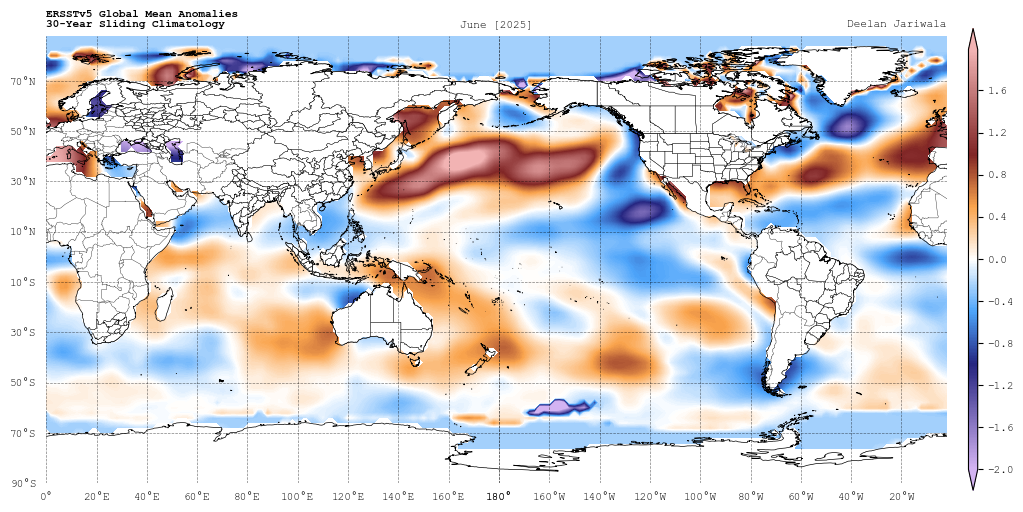

In [26]:
year = 2025
data2025 = anomalies('6', [year])

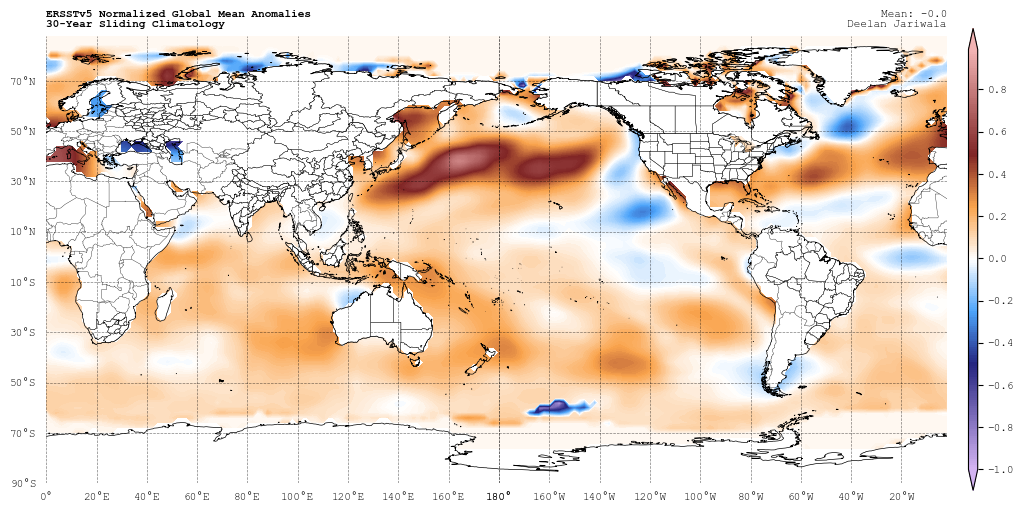

In [ ]:
# labelsize = 8 
# ax = map(20, labelsize)   

# ndata2025 = (data2025 - np.nanmin(data2025)) / (np.nanmax(data2025) - np.nanmin(data2025))
# ndata2025 = (ndata2025 * 2) - 1

# plt.contourf(data.lon, data.lat, ndata2025, origin='lower', levels = np.arange(-1, 1, .01), cmap = cmap.tempAnoms(), extend = 'both', transform=ccrs.PlateCarree(central_longitude=0))
# plt.title(f'ERSSTv5 Normalized Global Mean Anomalies\n30-Year Sliding Climatology' , fontweight='bold', fontsize=labelsize, loc='left')
# plt.title(f'Mean: {round(np.nanmean(data2025), 3)}\nDeelan Jariwala', fontsize=labelsize, loc='right')  
# cbar = plt.colorbar(orientation = 'vertical', aspect = 50, pad = .02)
# cbar.ax.tick_params(axis='both', labelsize=labelsize, left = False, bottom = False)
# # plt.savefig(r"C:\Users\deela\Downloads\ersstComposite.png", dpi = 400, bbox_inches = 'tight')
# plt.show()

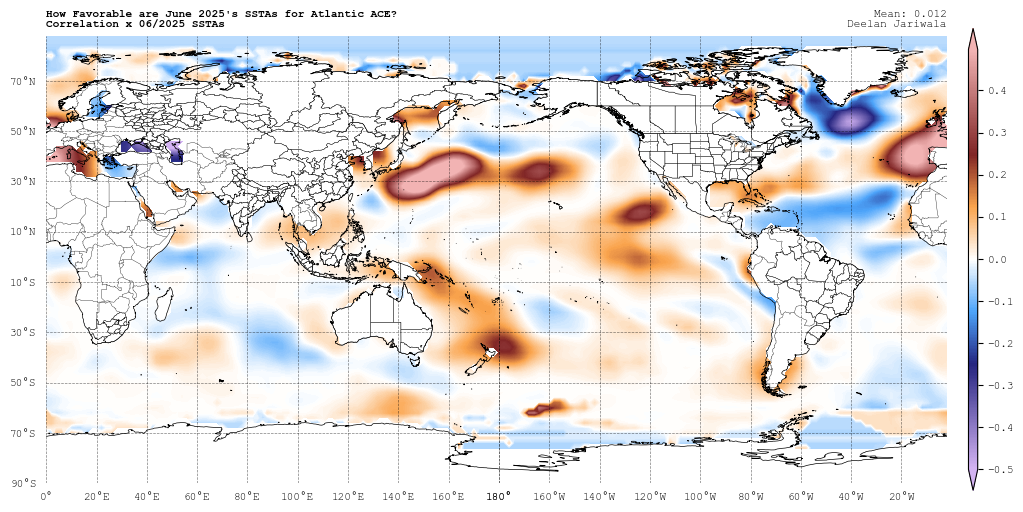

In [28]:
labelsize = 8 
ax = map(20, labelsize)    
#ax.set_extent([240, 359, 0, 70])

product = np.multiply(correlationArray, data2025)

plt.contourf(data.lon, data.lat, np.multiply(correlationArray, data2025), origin='lower', levels = np.arange(-.5, .5, .0025), cmap = cmap.tempAnoms(), extend = 'both', transform=ccrs.PlateCarree(central_longitude=0))
plt.title(f"How Favorable are June {year}'s SSTAs for Atlantic ACE?\nCorrelation x 06/{year} SSTAs" , fontweight='bold', fontsize=labelsize, loc='left')
plt.title(f'Mean: {round(np.nanmean(product), 3)}\nDeelan Jariwala', fontsize=labelsize, loc='right')  
cbar = plt.colorbar(orientation = 'vertical', aspect = 50, pad = .02)
cbar.ax.tick_params(axis='both', labelsize=labelsize, left = False, bottom = False)
plt.savefig(r"C:\Users\deela\Downloads\ersstComposite.png", dpi = 400, bbox_inches = 'tight')
plt.show()